In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [5]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [6]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [7]:
# train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['intent'])
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized*100, len(unique_values_normalized), len(unique_values_normalized_test))

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [11]:
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

In [12]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []


In [14]:
n_epoches = 20

In [15]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

100%|██████████| 31/31 [00:00<00:00, 431.63it/s]


Epoch 1, Train Loss: 1.7307770913940366, Val Loss: 0.9854127841611062


100%|██████████| 31/31 [00:00<00:00, 543.77it/s]


Epoch 2, Train Loss: 0.7920504290673692, Val Loss: 0.7163350485986278


100%|██████████| 31/31 [00:00<00:00, 505.67it/s]


Epoch 3, Train Loss: 0.5304818357956611, Val Loss: 0.5307965216136747


100%|██████████| 31/31 [00:00<00:00, 598.99it/s]


Epoch 4, Train Loss: 0.3695713732139034, Val Loss: 0.41783078062918877


100%|██████████| 31/31 [00:00<00:00, 516.14it/s]


Epoch 5, Train Loss: 0.26686451628299085, Val Loss: 0.3461903039245836


100%|██████████| 31/31 [00:00<00:00, 515.74it/s]


Epoch 6, Train Loss: 0.203220111365288, Val Loss: 0.3043328167930726


100%|██████████| 31/31 [00:00<00:00, 502.95it/s]


Epoch 7, Train Loss: 0.15430626940866143, Val Loss: 0.2699683518299172


100%|██████████| 31/31 [00:00<00:00, 571.91it/s]


Epoch 8, Train Loss: 0.11891823923373121, Val Loss: 0.2453902399828357


100%|██████████| 31/31 [00:00<00:00, 509.79it/s]


Epoch 9, Train Loss: 0.09324851617122352, Val Loss: 0.23282018550220998


100%|██████████| 31/31 [00:00<00:00, 475.91it/s]


Epoch 10, Train Loss: 0.07334065861147591, Val Loss: 0.21771166122127925


100%|██████████| 31/31 [00:00<00:00, 475.05it/s]


Epoch 11, Train Loss: 0.05853523675873244, Val Loss: 0.2107069323500318


100%|██████████| 31/31 [00:00<00:00, 513.83it/s]


Epoch 12, Train Loss: 0.047784240257342236, Val Loss: 0.20523793588302308


100%|██████████| 31/31 [00:00<00:00, 574.01it/s]


Epoch 13, Train Loss: 0.039484294210323845, Val Loss: 0.20068303234274348


100%|██████████| 31/31 [00:00<00:00, 496.05it/s]


Epoch 14, Train Loss: 0.032522089043395375, Val Loss: 0.19493126376501976


100%|██████████| 31/31 [00:00<00:00, 533.97it/s]


Epoch 15, Train Loss: 0.027449568528859575, Val Loss: 0.19637355560647143


100%|██████████| 31/31 [00:00<00:00, 515.73it/s]


Epoch 16, Train Loss: 0.022795222915701126, Val Loss: 0.19673508908148976


100%|██████████| 31/31 [00:00<00:00, 578.03it/s]


Epoch 17, Train Loss: 0.018936698587899398, Val Loss: 0.19229367602947017


100%|██████████| 31/31 [00:00<00:00, 560.85it/s]


Epoch 18, Train Loss: 0.016710180245631895, Val Loss: 0.19355282113857328


100%|██████████| 31/31 [00:00<00:00, 541.05it/s]


Epoch 19, Train Loss: 0.01423737632951273, Val Loss: 0.19952016442097845


100%|██████████| 31/31 [00:00<00:00, 554.27it/s]

Epoch 20, Train Loss: 0.012093743430233513, Val Loss: 0.19842622464808124


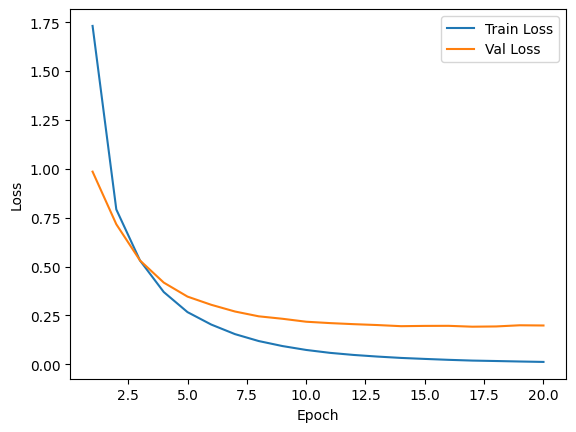

In [16]:
# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

0.763116757955882
(0.9564077295690683, 0.9591836734693877, 0.957152570085723, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# # Построение confusion matrix
# labels = data['intent'].unique()  # получите уникальные метки классов
# cm = confusion_matrix(test['intent'], predicted_intents, labels=labels)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.title(f'Logistic Regression')
# plt.show()

In [19]:
def plotCM(test, predictions, name:'str'):
    # Построение confusion matrix
    labels = test['intent'].unique()  # получите уникальные метки классов
    cm = confusion_matrix(test['intent'], predictions, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{name}')
    plt.show()

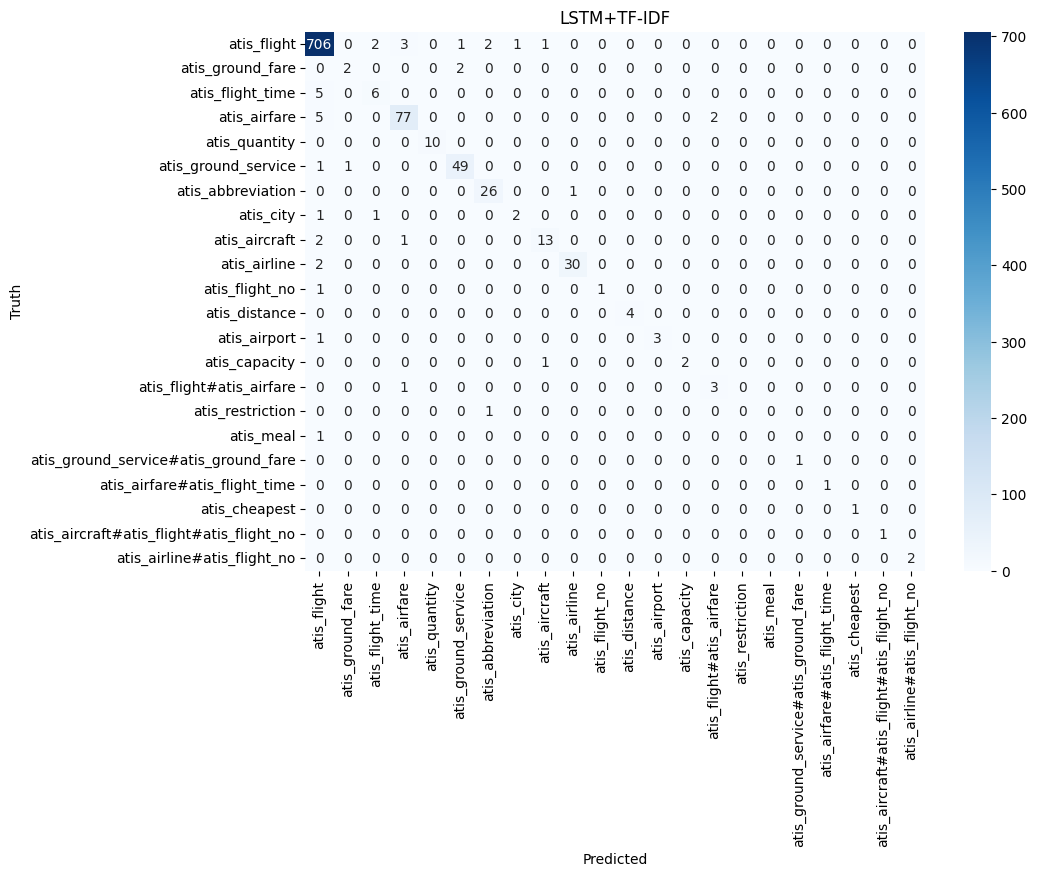

In [20]:
plotCM(test, predicted_intents,'LSTM+TF-IDF')

sentence-transformers/all-MiniLM-L6-v2

In [21]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [23]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [24]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 30


100%|██████████| 31/31 [00:00<00:00, 696.86it/s]


Epoch 1, Train Loss: 1.375673084440878, Val Loss: 1.0436704024191825


100%|██████████| 31/31 [00:00<00:00, 725.22it/s]


Epoch 2, Train Loss: 0.8299265357397371, Val Loss: 0.7108950191928495


100%|██████████| 31/31 [00:00<00:00, 722.88it/s]


Epoch 3, Train Loss: 0.5531613806546745, Val Loss: 0.5448059396397683


100%|██████████| 31/31 [00:00<00:00, 728.35it/s]


Epoch 4, Train Loss: 0.43388056603528685, Val Loss: 0.47087845831148084


100%|██████████| 31/31 [00:00<00:00, 741.61it/s]


Epoch 5, Train Loss: 0.3736719894459692, Val Loss: 0.4282572230985088


100%|██████████| 31/31 [00:00<00:00, 727.01it/s]


Epoch 6, Train Loss: 0.3271214989156036, Val Loss: 0.39365351512547464


100%|██████████| 31/31 [00:00<00:00, 755.35it/s]


Epoch 7, Train Loss: 0.29426305987319706, Val Loss: 0.36881658098390024


100%|██████████| 31/31 [00:00<00:00, 705.61it/s]


Epoch 8, Train Loss: 0.26806814037263393, Val Loss: 0.3494725985632789


100%|██████████| 31/31 [00:00<00:00, 721.20it/s]


Epoch 9, Train Loss: 0.24937888706829084, Val Loss: 0.3306108316586864


100%|██████████| 31/31 [00:00<00:00, 731.13it/s]


Epoch 10, Train Loss: 0.23443106037832923, Val Loss: 0.3346146845048474


100%|██████████| 31/31 [00:00<00:00, 752.60it/s]


Epoch 11, Train Loss: 0.21384561772189908, Val Loss: 0.31725161690865794


100%|██████████| 31/31 [00:00<00:00, 719.85it/s]


Epoch 12, Train Loss: 0.20088151872347473, Val Loss: 0.305429597895953


100%|██████████| 31/31 [00:00<00:00, 763.44it/s]


Epoch 13, Train Loss: 0.18948303047820167, Val Loss: 0.29389070214763763


100%|██████████| 31/31 [00:00<00:00, 750.95it/s]


Epoch 14, Train Loss: 0.1768562967683804, Val Loss: 0.2790887126278493


100%|██████████| 31/31 [00:00<00:00, 750.89it/s]


Epoch 15, Train Loss: 0.16387614721463897, Val Loss: 0.28413617058146384


100%|██████████| 31/31 [00:00<00:00, 757.33it/s]


Epoch 16, Train Loss: 0.1559239943369718, Val Loss: 0.26610334445872613


100%|██████████| 31/31 [00:00<00:00, 659.15it/s]


Epoch 17, Train Loss: 0.1494207707454719, Val Loss: 0.26584653436176237


100%|██████████| 31/31 [00:00<00:00, 747.72it/s]


Epoch 18, Train Loss: 0.13926522296427166, Val Loss: 0.2492270175247423


100%|██████████| 31/31 [00:00<00:00, 670.18it/s]


Epoch 19, Train Loss: 0.12976037003731322, Val Loss: 0.2557007892718238


100%|██████████| 31/31 [00:00<00:00, 602.17it/s]


Epoch 20, Train Loss: 0.1254099073456758, Val Loss: 0.2407107124886205


100%|██████████| 31/31 [00:00<00:00, 749.86it/s]


Epoch 21, Train Loss: 0.12035058696470144, Val Loss: 0.24323140096760565


100%|██████████| 31/31 [00:00<00:00, 669.15it/s]


Epoch 22, Train Loss: 0.1139156655645219, Val Loss: 0.23901938358622213


100%|██████████| 31/31 [00:00<00:00, 751.33it/s]


Epoch 23, Train Loss: 0.1069289041462086, Val Loss: 0.23827075237228024


100%|██████████| 31/31 [00:00<00:00, 760.15it/s]


Epoch 24, Train Loss: 0.10102637685930073, Val Loss: 0.2373951657284652


100%|██████████| 31/31 [00:00<00:00, 736.40it/s]


Epoch 25, Train Loss: 0.09697940689906226, Val Loss: 0.23022099043573102


100%|██████████| 31/31 [00:00<00:00, 737.40it/s]


Epoch 26, Train Loss: 0.09064649566376613, Val Loss: 0.2305751859901413


100%|██████████| 31/31 [00:00<00:00, 744.31it/s]


Epoch 27, Train Loss: 0.08802691295395716, Val Loss: 0.23945882291563095


100%|██████████| 31/31 [00:00<00:00, 711.76it/s]


Epoch 28, Train Loss: 0.08431759303814526, Val Loss: 0.24946723962503095


100%|██████████| 31/31 [00:00<00:00, 750.80it/s]


Epoch 29, Train Loss: 0.08020152798774889, Val Loss: 0.2249895057250415


100%|██████████| 31/31 [00:00<00:00, 729.76it/s]


Epoch 30, Train Loss: 0.07780909817271187, Val Loss: 0.22764368956127473


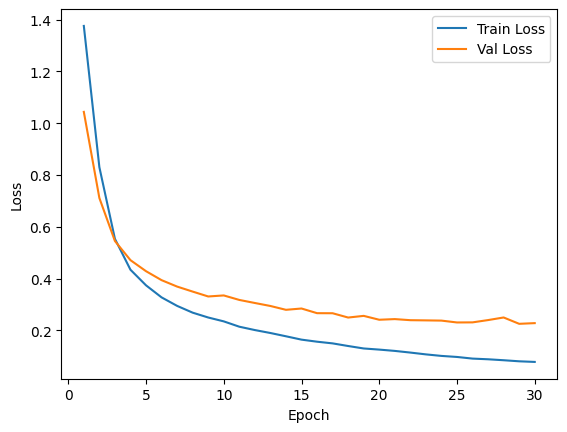

In [26]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

precision_recall_fscore weighted (0.9421994119650959, 0.9469387755102041, 0.9405086410048332, None)
balanced_accuracy 0.5618648735715103


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


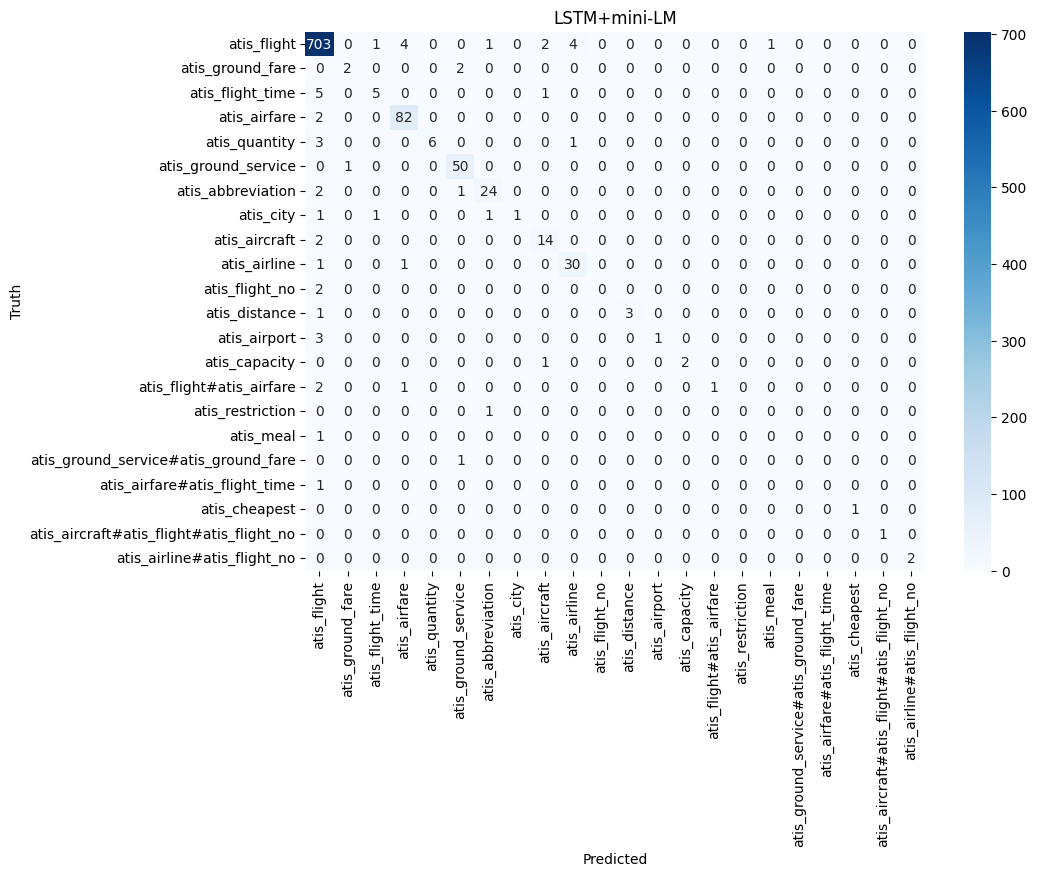

In [28]:
plotCM(test, predicted_intents, 'LSTM+mini-LM')

M-USE